In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(style='ticks', context='talk', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})

%matplotlib inline


folder = '/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure3_modalities_functional'

import flotilla

study = flotilla.embark('singlecell_pnm_figure2_modalities')
not_outliers = study.splicing.singles.index.difference(study.splicing.outliers.index)

psi = study.splicing.singles.ix[not_outliers]
grouped = psi.groupby(study.sample_id_to_phenotype)
psi_filtered = grouped.apply(lambda x: x.dropna(axis=1, thresh=20))


2015-09-29 18:40:07	Reading datapackage from /home/obotvinnik/flotilla_projects/singlecell_pnm_figure2_modalities/datapackage.json
2015-09-29 18:40:07	Parsing datapackage to create a Study object
2015-09-29 18:41:14	Initializing Study
2015-09-29 18:41:14	Initializing Predictor configuration manager for Study
2015-09-29 18:41:14	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2015-09-29 18:41:14	Added ExtraTreesClassifier to default predictors
2015-09-29 18:41:14	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2015-09-29 18:41:14	Added ExtraTreesRegressor to default predictors
2015-09-29 18:41:14	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2015-09-29 18:41:14	Added GradientBoostingClassifier to default predictors
2015-09-29 18:41:14	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boost

In [2]:
modalities_tidy = study.supplemental.modalities_tidy.copy()

This uses the CSVs created in [0.2.09]

In [10]:
basewise_folder = '/projects/ps-yeolab/obotvinnik/singlecell_pnms'
constitutive_upstream = pd.read_csv('{}/constitutive_exons_upstream200_placental_mammal_conservation.csv'.format(basewise_folder),
                                   index_col=0)
constitutive_downstream = pd.read_csv('{}/constitutive_exons_downstream200_placental_mammal_conservation.csv'.format(basewise_folder),
                                   index_col=0)

In [18]:
consitutitives = {'upstream': constitutive_upstream, 'downstream': constitutive_downstream}

tidy_dfs = []
for direction, df in consitutitives.items():
    mean_conservation = df.mean()
    mean_conservation.index = mean_conservation.index.astype(int) + 1
    tidy = mean_conservation.reset_index()
    tidy = tidy.rename(columns={'index':'genome_direction_nt', 0: 'Conservation'})
    tidy['direction'] = direction
    tidy_dfs.append(tidy)
tidy_constitutive = pd.concat(tidy_dfs, ignore_index=True)
print tidy_constitutive.shape
tidy_constitutive.head()

(400, 3)


,genome_direction_nt,Conservation,direction
0,1,0.775291,downstream
1,2,0.771573,downstream
2,3,0.720895,downstream
3,4,0.618678,downstream
4,5,0.545459,downstream


In [23]:
tidy_constitutive['modality'] = 'constitutive'

In [28]:
import matplotlib as mpl

map(lambda x: mpl.colors.rgb2hex(x) if not isinstance(x, str) else x, MODALITY_PALETTE)

[u'#64b5cd', u'#ccb974', u'#c44e52', u'#8172b2', 'lightgrey']

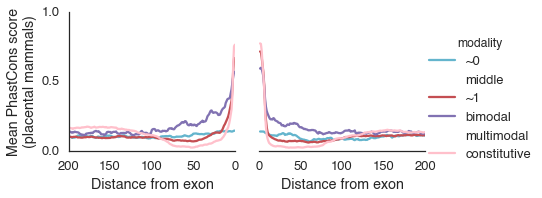

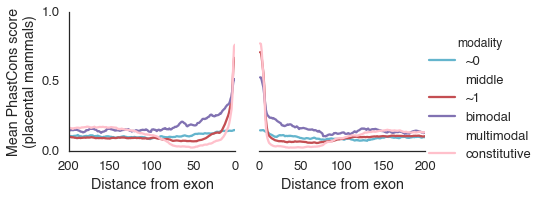

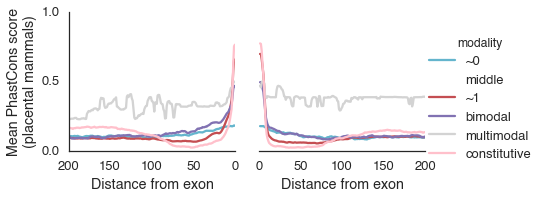

In [34]:
from modish import MODALITY_ORDER, MODALITY_PALETTE
bed_folder = '/projects/ps-yeolab/obotvinnik/singlecell_pnms'
upstream = pd.read_csv('{}/skipped_exon_exon2_upstream200_placental_mammal_conservation.csv'.format(bed_folder), 
                       index_col=0)
downstream = pd.read_csv('{}/skipped_exon_exon2_downstream200_placental_mammal_conservation.csv'.format(bed_folder), 
                         index_col=0)

intron_conservations = {'upstream': upstream, 
                        'downstream': downstream}

modality_palette = map(lambda x: mpl.colors.rgb2hex(x) if not isinstance(x, str) else x, MODALITY_PALETTE)

modality_order_constit = MODALITY_ORDER + ['constitutive']
modality_palette_constit = modality_palette + ['pink']

for phenotype, phenotype_df in modalities_tidy.groupby('phenotype'):
    modalities = phenotype_df.set_index('event_name').modality
    modalities = modalities.drop(modalities.index.get_duplicates())
    
    
    dfs = [tidy_constitutive]
    for intron_name, intron_conservation in intron_conservations.items():
        mean_conservation = intron_conservation.groupby(modalities).mean()
        mean_conservation.columns = mean_conservation.columns.astype(int) + 1
        tidy = mean_conservation.unstack().reset_index()
        tidy = tidy.rename(columns={'level_0':'genome_direction_nt', 0: 'Conservation'})
        tidy['direction'] = intron_name
        dfs.append(tidy)
#         var_conservation = intron_conservation.groupby(modalities).var()
    modality_basewise_conservation = pd.concat(dfs, ignore_index=True)
    
    g = sns.FacetGrid(modality_basewise_conservation, hue='modality', hue_order=modality_order_constit,
                     palette=modality_palette_constit, 
                      col='direction', sharex=False,
                      col_order=['upstream', 'downstream'], size=3)
    g.map(plt.plot, 'genome_direction_nt', 'Conservation')
    for ax in g.axes.flat:
        ax.locator_params(nbins=4)
#         ax.locator_params('y', nbins=4)
        if ax.is_first_col():
            ax.set(ylabel='Mean PhastCons score\n(placental mammals)',
                   xticklabels=list(reversed([int(x) for x in ax.get_xticks()])))
        else:
            sns.despine(ax=ax, left=True)
            ax.yaxis.set_ticks_position('none')
    g.set(xlabel='Distance from exon', title='', ylim=(0, 1))
    g.add_legend();
    g.savefig('{}/{}_intron_basewise_conservation.pdf'.format(folder, phenotype))

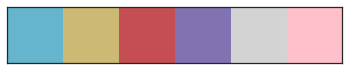

In [32]:
sns.palplot(modality_palette_constit)